In [ ]:
# # pre-requisite install flwr
# # --- Cell 1:  Imports and Installations ---
# print("Installing Flower (flwr)...")
# %pip install flwr[simulation] tensorflow -q

In [ ]:
# # imports
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import flwr as fl

# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.exceptions import DataConversionWarning
# import warnings

# # Suppress warnings for cleaner output
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=FutureWarning)
# tf.get_logger().setLevel('ERROR')

# print("\nLibraries imported successfully.")
# print(f"TensorFlow version: {tf.__version__}")
# print(f"Flower version: {fl.__version__}")

In [ ]:
# # --- Cell 2:  Global Configuration & Feature Definitions ---
# CLIENT_CITIES = ['Delhi', 'Beijing', 'Mexico City', 'Los Angeles']
# TARGET = 'hospital_admissions'
# ENV_FEATURES = [
#     'aqi', 'pm2_5', 'pm10', 'no2', 'o3', 'temperature',
#     'humidity', 'hospital_capacity', 'occupancy_ratio'
# ]
# TEXT_FEATURE = 'population_density'
# POPULATION_CLASSES = ['Rural', 'Urban', 'Suburban']
# WEARABLE_FEATURES = [
#     'heart_rate', 'oxygen_saturation', 'steps',
#     'sleep_hours', 'respiratory_rate', 'body_temp'
# ]
# IMG_SHAPE = (2, 3, 1) # 2 rows, 3 columns, 1 channel
# DATA_FILE_PATH = '/content/MLOPs_data.csv' # Make sure this path is correct

# print("Configuration and feature lists defined.")

In [ ]:
# # --- Cell 3: ⚙️ Data Preprocessing Helper Function ---
# env_scaler = StandardScaler()
# wearable_scaler = StandardScaler()
# text_encoder = LabelEncoder()

# try:
#     print("Fitting preprocessors (Scalers and Encoders)...")
#     full_df = pd.read_csv(DATA_FILE_PATH, encoding='latin1')
#     env_scaler.fit(full_df[ENV_FEATURES])
#     wearable_scaler.fit(full_df[WEARABLE_FEATURES])
#     text_encoder.fit(POPULATION_CLASSES)
#     print("Preprocessors fitted successfully.")
# except Exception as e:
#     print(f"--- FATAL ERROR: Could not read data to fit preprocessors. ---")
#     print(f"Error: {e}")
#     # We add 'raise' to stop the script if this fails
#     raise


# def load_and_preprocess_data_for_client(client_city: str):
#     """
#     Loads the main dataset, filters for a specific city, and preprocesses
#     it into the 3-input format for our multi-modal model.
#     """
#     df = pd.read_csv(DATA_FILE_PATH, encoding='latin1')
#     client_df = df[df['city'] == client_city].copy()

#     if len(client_df) == 0:
#         raise ValueError(f"No data found for city: {client_city}")

#     # 1. Preprocess Branch 1: Environmental Data
#     X_env = env_scaler.transform(client_df[ENV_FEATURES])

#     # 2. Preprocess Branch 2: Text Data
#     X_text = text_encoder.transform(client_df[TEXT_FEATURE])

#     # 3. Preprocess Branch 3: Wearable/Image Data
#     X_wearable_scaled = wearable_scaler.transform(client_df[WEARABLE_FEATURES])
#     X_image = X_wearable_scaled.reshape((-1, IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))

#     # 4. Prepare the Target (Y)
#     y = client_df[TARGET].values

#     # 5. Split into Train/Test for this client
#     indices = np.arange(len(y))
#     train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

#     X_train = [ X_env[train_indices], X_text[train_indices], X_image[train_indices] ]
#     y_train = y[train_indices]

#     X_test = [ X_env[test_indices], X_text[test_indices], X_image[test_indices] ]
#     y_test = y[test_indices]

#     return (X_train, y_train), (X_test, y_test)

# # --- Test the function for one client ---
# try:
#     (X_train_delhi, y_train_delhi), (X_test_delhi, y_test_delhi) = load_and_preprocess_data_for_client('Delhi')
#     print(f"\n--- Data loaded for Delhi (test) ---")
#     print(f"Branch 1 (Env) train shape: {X_train_delhi[0].shape}")
#     print(f"Branch 2 (Text) train shape: {X_train_delhi[1].shape}")
#     print(f"Branch 3 (Img) train shape: {X_train_delhi[2].shape}")
#     print(f"Target train shape: {y_train_delhi.shape}")
# except Exception as e:
#     print(f"\nError in test-loading data: {e}")


In [ ]:
# # --- Cell 4:  The Multi-Modal Model Architecture ---
# # This code will now run (the faulty 'if' check is removed)

# def build_multi_modal_model():
#     """
#     Creates our 3-branch 'fusion' model.
#     """
#     # 1. Branch 1: Environmental/Numerical Input
#     input_env = layers.Input(shape=(len(ENV_FEATURES),), name="env_input")
#     x_env = layers.Dense(32, activation="relu")(input_env)
#     x_env = layers.Dropout(0.3)(x_env)
#     x_env_out = layers.Dense(16, activation="relu")(x_env)

#     # 2. Branch 2: Text Input
#     input_text = layers.Input(shape=(1,), name="text_input")
#     x_text = layers.Embedding(input_dim=len(POPULATION_CLASSES), output_dim=4)(input_text)
#     x_text = layers.Flatten()(x_text)
#     x_text_out = layers.Dense(4, activation="relu")(x_text)

#     # 3. Branch 3: Wearable/Image Input
#     input_image = layers.Input(shape=IMG_SHAPE, name="wearable_image_input")
#     x_img = layers.Conv2D(8, (2,2), activation="relu", padding="same")(input_image)
#     x_img = layers.MaxPooling2D((1,1))(x_img)
#     x_img = layers.Flatten()(x_img)
#     x_img_out = layers.Dense(8, activation="relu")(x_img)

#     # 4. Fusion Layer
#     concatenated = layers.concatenate([x_env_out, x_text_out, x_img_out])

#     # Final prediction layers
#     x = layers.Dense(32, activation="relu")(concatenated)
#     x = layers.Dropout(0.5)(x)
#     output_layer = layers.Dense(1, activation="linear", name="output")(x)

#     # Build and compile the model
#     model = keras.Model(
#         inputs=[input_env, input_text, input_image],
#         outputs=output_layer,
#         name="3_branch_health_model"
#     )
#     model.compile(
#         loss="mse", # Mean Squared Error
#         optimizer="adam",
#         metrics=["mae"] # Mean Absolute Error
#     )
#     return model

# # --- Test the model build ---
# model = build_multi_modal_model()
# print("\n--- Model Summary ---")
# model.summary()

In [ ]:
# # --- Cell 5:  Defining the Flower Client ---
# # This part was already correct.

# class HealthRiskClient(fl.client.NumPyClient):
#     """
#     This is the client-side logic for Federated Learning.
#     Each client (city) will be an instance of this class.
#     """
#     def __init__(self, client_city):
#         self.client_city = client_city
#         self.model = None
#         self.X_train = None
#         self.y_train = None
#         self.X_test = None
#         self.y_test = None
#         print(f"Client for {client_city} created.")

#     def get_parameters(self, config):
#         if self.model is None:
#             self.model = build_multi_modal_model()
#         print(f"\n[Client {self.client_city}] Sending parameters to server.")
#         return self.model.get_weights()

#     def fit(self, parameters, config):
#         if self.X_train is None:
#             print(f"[Client {self.client_city}] Loading local data...")
#             (self.X_train, self.y_train), (self.X_test, self.y_test) = \
#                 load_and_preprocess_data_for_client(self.client_city)
#             print(f"[Client {self.client_city}] Data loaded. {len(self.y_train)} train samples.")

#         if self.model is None:
#             self.model = build_multi_modal_model()

#         self.model.set_weights(parameters)

#         print(f"[Client {self.client_city}] Training local model...")
#         self.model.fit(self.X_train, self.y_train,
#                        epochs=1,
#                        batch_size=32,
#                        validation_split=0.1,
#                        verbose=1)

#         print(f"[Client {self.client_city}] Training complete, returning parameters.")
#         return self.model.get_weights(), len(self.y_train), {}

#     def evaluate(self, parameters, config):
#         print(f"[Client {self.client_city}] Evaluating model on local test set...")

#         if self.X_test is None:
#              _, (self.X_test, self.y_test) = \
#                 load_and_preprocess_data_for_client(self.client_city)

#         if self.model is None:
#             self.model = build_multi_modal_model()
#         self.model.set_weights(parameters)

#         loss, mae = self.model.evaluate(self.X_test, self.y_test, verbose=0)

#         print(f"[Client {self.client_city}] Evaluation: Loss={loss:.4f}, MAE={mae:.4f}")
#         return loss, len(self.y_test), {"mae": mae}

# def client_fn(cid: str) -> HealthRiskClient:
#     """A function to create a client instance."""
#     city_name = CLIENT_CITIES[int(cid)]
#     return HealthRiskClient(client_city=city_name)

# print("\nFlower Client defined successfully.")


In [ ]:
# # --- Cell 6:  Running the Federated Learning Simulation ---
# # This code will now run (the faulty 'if' check is removed)

# # 1. Define our Aggregation Strategy
# strategy = fl.server.strategy.FedAvg(
#     min_fit_clients=len(CLIENT_CITIES),       # Wait for all 4 clients to train
#     min_evaluate_clients=len(CLIENT_CITIES),  # Evaluate on all 4 clients
#     min_available_clients=len(CLIENT_CITIES), # Wait for all 4 clients to be available
# )

# # 2. Start the Simulation
# print("\n---  Starting Federated Learning Simulation (3 Rounds) ---")

# history = fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=len(CLIENT_CITIES),
#     config=fl.server.ServerConfig(num_rounds=3), # Run for 3 rounds
#     strategy=strategy,
#     client_resources={"num_cpus": 1, "num_gpus": 0}, # Basic resources
# )

# print("---  !!Simulation Finished!! ---")


Installing Flower (flwr)...

Libraries imported successfully.
TensorFlow version: 2.19.0
Flower version: 1.23.0
Configuration and feature lists defined.
Fitting preprocessors (Scalers and Encoders)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Preprocessors fitted successfully.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- Data loaded for Delhi (test) ---
Branch 1 (Env) train shape: (21172, 9)
Branch 2 (Text) train shape: (21172,)
Branch 3 (Img) train shape: (21172, 2, 3, 1)
Target train shape: (21172,)

--- Model Summary ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Model: "3_branch_health_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ wearable_image_inp… │ (None, 2, 3, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ env_input           │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 2, 3, 8)   │         40 │ wearable_image_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        320 │ env_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 4)      │         12 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 2, 3, 8)   │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 48)        │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4)         │         20 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 8)         │        392 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 28)        │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense_12[0][0],   │
│                     │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │        928 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout



Flower Client defined successfully.

---  Starting Federated Learning Simulation (3 Rounds) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-11-17 14:57:53,955	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7850579559.0, 'object_store_memory': 3925289779.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=4788) 2025-11-17 14:58:09.662358: E external/l

(ClientAppActor pid=4788) Client for Beijing created.
(ClientAppActor pid=4788) 
(ClientAppActor pid=4788) [Client Beijing] Sending parameters to server.


(ClientAppActor pid=4788) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)             This is a deprecated feature. It will be removed
(ClientAppActor pid=4788)             entirely in future versions of Flower.
(ClientAppActor pid=4788)         
(ClientAppActor pid=4788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=4788) Client for Mexico City created.
(ClientAppActor pid=4788) [Client Mexico City] Loading local data...


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         


(ClientAppActor pid=4787) Client for Delhi created.
(ClientAppActor pid=4787) [Client Delhi] Loading local data...
(ClientAppActor pid=4788) [Client Mexico City] Data loaded. 10701 train samples.
(ClientAppActor pid=4788) [Client Mexico City] Training local model...
(ClientAppActor pid=4787) [Client Delhi] Data loaded. 21172 train samples.
(ClientAppActor pid=4787) [Client Delhi] Training local model...
  1/301 ━━━━━━━━━━━━━━━━━━━━ 18:32 4s/step - loss: 70.5692 - mae: 7.5295
 28/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 71.9625 - mae: 7.5300
 52/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 66.6682 - mae: 7.1945
 80/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.2311 - mae: 6.7331
109/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.8763 - mae: 6.3313
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.8662 - mae: 5.0723
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 38.5896 - mae: 5.0500 - val_loss: 12.7924 - val_mae: 2.8323
(ClientAppActor pid=4788) [Client Mexico City] Training 

(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         
(ClientAppActor pid=4788) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=4788)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=4788)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=4788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=4787) 2025-11-17 14:58:22.626730: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: 

(ClientAppActor pid=4787) [Client Delhi] Training complete, returning parameters.
(ClientAppActor pid=4787) Client for Los Angeles created.
(ClientAppActor pid=4787) [Client Los Angeles] Loading local data...
(ClientAppActor pid=4788) [Client Beijing] Data loaded. 17651 train samples.
(ClientAppActor pid=4788) [Client Beijing] Training local model...
(ClientAppActor pid=4787) [Client Los Angeles] Data loaded. 7202 train samples.
(ClientAppActor pid=4787) [Client Los Angeles] Training local model...
 17/497 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 68.2416 - mae: 7.4450  
  1/596 ━━━━━━━━━━━━━━━━━━━━ 36:06 4s/step - loss: 81.4680 - mae: 8.1264
 28/596 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 69.9330 - mae: 7.5246
588/596 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.7290 - mae: 4.4318 [repeated 25x across cluster]
596/596 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 30.5779 - mae: 4.4190 - val_loss: 11.6591 - val_mae: 2.7116
 74/203 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.3642 - mae: 6.790

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4787) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=4787)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=4787)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=4787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppAct

(ClientAppActor pid=4787) [Client Los Angeles] Training complete, returning parameters.
(ClientAppActor pid=4787) Client for Delhi created.
(ClientAppActor pid=4787) [Client Delhi] Evaluating model on local test set...
(ClientAppActor pid=4788) Client for Los Angeles created.
(ClientAppActor pid=4788) [Client Los Angeles] Evaluating model on local test set...
(ClientAppActor pid=4788) [Client Los Angeles] Evaluation: Loss=12.4231, MAE=2.7712
(ClientAppActor pid=4788) Client for Mexico City created.
(ClientAppActor pid=4788) [Client Mexico City] Evaluating model on local test set...


(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         
(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         


(ClientAppActor pid=4787) [Client Delhi] Evaluation: Loss=11.9622, MAE=2.7257
(ClientAppActor pid=4787) Client for Beijing created.
(ClientAppActor pid=4787) [Client Beijing] Evaluating model on local test set...


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=4788) [Client Mexico City] Evaluation: Loss=12.1721, MAE=2.7393
 13/203 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 73.7651 - mae: 7.7305  
489/497 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.7673 - mae: 4.5945 [repeated 21x across cluster]
(ClientAppActor pid=4787) [Client Beijing] Evaluation: Loss=11.7869, MAE=2.7020
(ClientAppActor pid=4787) Client for Beijing created.
(ClientAppActor pid=4787) [Client Beijing] Loading local data...


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         


(ClientAppActor pid=4788) Client for Mexico City created.
(ClientAppActor pid=4788) [Client Mexico City] Loading local data...
(ClientAppActor pid=4787) [Client Beijing] Data loaded. 17651 train samples.
(ClientAppActor pid=4788) [Client Mexico City] Data loaded. 10701 train samples.
(ClientAppActor pid=4787) [Client Beijing] Training local model...
(ClientAppActor pid=4788) [Client Mexico City] Training local model...
 16/497 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 17.0319 - mae: 3.2290  
497/497 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 32.5663 - mae: 4.5778 - val_loss: 10.9787 - val_mae: 2.6378
  1/301 ━━━━━━━━━━━━━━━━━━━━ 24:36 5s/step - loss: 18.0294 - mae: 3.3879
 44/497 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16.6149 - mae: 3.2220
 28/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 17.1470 - mae: 3.2535
 74/497 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16.3294 - mae: 3.1984
310/497 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.5184 - mae: 3.1196
301/301 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/st

(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         
(ClientAppActor pid=4788) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=4788)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=4788)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=4788) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


(ClientAppActor pid=4788) [Client Delhi] Data loaded. 21172 train samples.
(ClientAppActor pid=4788) [Client Delhi] Training local model...


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         


(ClientAppActor pid=4787) [Client Beijing] Training complete, returning parameters.
(ClientAppActor pid=4787) Client for Los Angeles created.
(ClientAppActor pid=4787) [Client Los Angeles] Loading local data...
(ClientAppActor pid=4787) [Client Los Angeles] Data loaded. 7202 train samples.
(ClientAppActor pid=4787) [Client Los Angeles] Training local model...
  1/596 ━━━━━━━━━━━━━━━━━━━━ 32:29 3s/step - loss: 17.0912 - mae: 3.4459
496/497 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.2662 - mae: 3.0939 [repeated 22x across cluster]
 32/596 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.6638 - mae: 3.1598
373/497 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4256 - mae: 3.1098 [repeated 3x across cluster]
  1/203 ━━━━━━━━━━━━━━━━━━━━ 11:31 3s/step - loss: 13.1754 - mae: 2.8172
497/497 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 15.2638 - mae: 3.0937 - val_loss: 9.9021 - val_mae: 2.4926
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 15.2262 - mae: 3.1123 - val_loss: 10.9056 - val_mae: 2.6261
(Cl

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4787) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=4787)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=4787)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=4787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppAct

(ClientAppActor pid=4787) [Client Los Angeles] Training complete, returning parameters.
(ClientAppActor pid=4787) Client for Mexico City created.
(ClientAppActor pid=4787) [Client Mexico City] Evaluating model on local test set...
(ClientAppActor pid=4788) Client for Los Angeles created.
(ClientAppActor pid=4788) [Client Los Angeles] Evaluating model on local test set...


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         


(ClientAppActor pid=4787) [Client Mexico City] Evaluation: Loss=10.7339, MAE=2.5584
(ClientAppActor pid=4787) Client for Delhi created.
(ClientAppActor pid=4787) [Client Delhi] Evaluating model on local test set...
577/596 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2791 - mae: 3.0903 [repeated 23x across cluster]
 28/203 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3633 - mae: 3.1200
593/596 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2656 - mae: 3.0888 [repeated 5x across cluster]
(ClientAppActor pid=4788) [Client Los Angeles] Evaluation: Loss=11.0253, MAE=2.5967
(ClientAppActor pid=4788) Client for Beijing created.
(ClientAppActor pid=4788) [Client Beijing] Evaluating model on local test set...


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=4788) [Client Beijing] Evaluation: Loss=10.4484, MAE=2.5372
596/596 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 15.2621 - mae: 3.0884 - val_loss: 9.6327 - val_mae: 2.4520
(ClientAppActor pid=4787) [Client Delhi] Evaluation: Loss=10.5316, MAE=2.5535
(ClientAppActor pid=4787) [Client Los Angeles] Loading local data...
(ClientAppActor pid=4788) [Client Mexico City] Loading local data...


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         


(ClientAppActor pid=4787) [Client Los Angeles] Data loaded. 7202 train samples.
(ClientAppActor pid=4788) Client for Mexico City created.
(ClientAppActor pid=4787) Client for Los Angeles created.
(ClientAppActor pid=4788) [Client Mexico City] Data loaded. 10701 train samples.
(ClientAppActor pid=4787) [Client Los Angeles] Training local model...
(ClientAppActor pid=4788) [Client Mexico City] Training local model...
  1/203 ━━━━━━━━━━━━━━━━━━━━ 11:07 3s/step - loss: 14.3591 - mae: 2.9532
 16/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6597 - mae: 2.8382 
 29/203 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.6144 - mae: 3.0569
 41/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.1665 - mae: 2.9033
192/203 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.7263 - mae: 2.9395


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4787) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=4787)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=4787)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=4787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 6x across cluster]


203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 13.7141 - mae: 2.9376 - val_loss: 9.2483 - val_mae: 2.4083
(ClientAppActor pid=4787) [Client Los Angeles] Training complete, returning parameters.
(ClientAppActor pid=4787) Client for Delhi created.
(ClientAppActor pid=4787) [Client Delhi] Loading local data...
(ClientAppActor pid=4788) [Client Mexico City] Training complete, returning parameters.
(ClientAppActor pid=4788) Client for Beijing created.
(ClientAppActor pid=4788) [Client Beijing] Loading local data...


(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         


(ClientAppActor pid=4787) [Client Delhi] Data loaded. 21172 train samples.
(ClientAppActor pid=4787) [Client Delhi] Training local model...
(ClientAppActor pid=4788) [Client Beijing] Data loaded. 17651 train samples.
(ClientAppActor pid=4788) [Client Beijing] Training local model...
  1/596 ━━━━━━━━━━━━━━━━━━━━ 32:55 3s/step - loss: 11.0138 - mae: 2.5694
270/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.3895 - mae: 2.9075 [repeated 13x across cluster]
 32/596 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.2911 - mae: 2.9489
  1/497 ━━━━━━━━━━━━━━━━━━━━ 26:55 3s/step - loss: 11.0201 - mae: 2.6574
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.3804 - mae: 2.9059
106/596 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.0129 - mae: 2.9414
116/596 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 14.0033 - mae: 2.9421
169/596 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13.9412 - mae: 2.9433
177/596 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13.9289 - mae: 2.9429
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


497/497 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 13.2650 - mae: 2.8810 - val_loss: 6.4786 - val_mae: 1.9906
(ClientAppActor pid=4788) [Client Beijing] Training complete, returning parameters.
592/596 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.2870 - mae: 2.8814 [repeated 59x across cluster]
 22/497 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 14.4108 - mae: 3.0177
(ClientAppActor pid=4787) [Client Delhi] Training complete, returning parameters.
(ClientAppActor pid=4787) Client for Mexico City created.
(ClientAppActor pid=4787) [Client Mexico City] Evaluating model on local test set...


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4787) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=4787)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=4787)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=4787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         


(ClientAppActor pid=4788) Client for Los Angeles created.
(ClientAppActor pid=4788) [Client Los Angeles] Evaluating model on local test set...
(ClientAppActor pid=4788) [Client Los Angeles] Evaluation: Loss=7.6171, MAE=2.1394
461/497 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3189 - mae: 2.8873 [repeated 3x across cluster]
(ClientAppActor pid=4787) [Client Mexico City] Evaluation: Loss=7.2697, MAE=2.0832
(ClientAppActor pid=4787) Client for Delhi created.
(ClientAppActor pid=4787) [Client Delhi] Evaluating model on local test set...
(ClientAppActor pid=4788) Client for Beijing created.
(ClientAppActor pid=4788) [Client Beijing] Evaluating model on local test set...


(ClientAppActor pid=4787) 
(ClientAppActor pid=4787)         
(ClientAppActor pid=4788) 
(ClientAppActor pid=4788)         
INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 56.53s
INFO :      	History (loss, distributed):
INFO :      		round 1: 12.005783266638916
INFO :      		round 2: 10.606577175271903
INFO :      		round 3: 7.27773135681545
INFO :      


(ClientAppActor pid=4787) [Client Delhi] Evaluation: Loss=7.2349, MAE=2.0915
---  !!Simulation Finished!! ---

--- Federated Learning Results ---
Distributed Loss (MSE) over 3 rounds:
Round 1: Avg. Loss = 12.0058
Round 2: Avg. Loss = 10.6066
Round 3: Avg. Loss = 7.2777


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


(ClientAppActor pid=4788) [Client Beijing] Evaluation: Loss=7.1955, MAE=2.0919


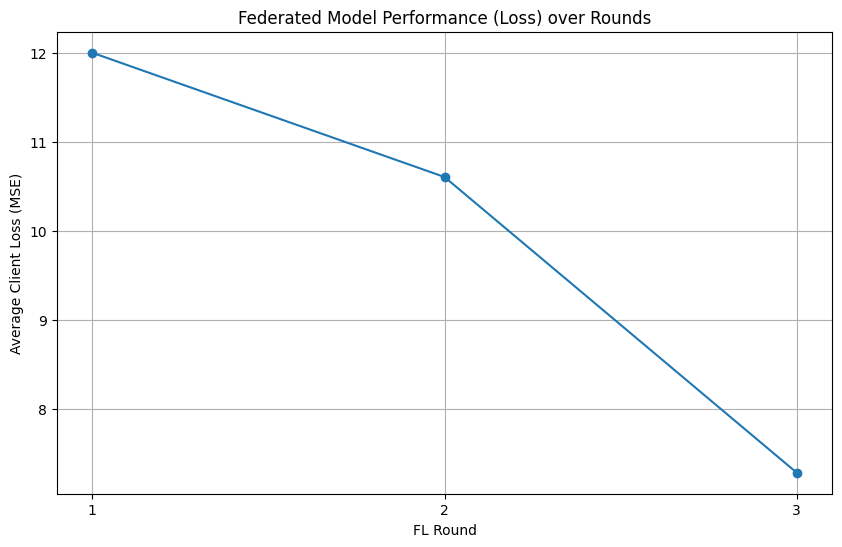


No 'mae' metric found in history.metrics_distributed.


In [ ]:
# # --- Cell 7: 📈 Analyzing Results ---
# # This will now have results to analyze

# if 'history' in locals():
#     print("\n--- Federated Learning Results ---")

#     # Check for distributed (client-side) losses
#     if history.losses_distributed:
#         rounds = [r for r, _ in history.losses_distributed]
#         losses = [l for _, l in history.losses_distributed]

#         print(f"Distributed Loss (MSE) over {len(rounds)} rounds:")
#         for r, l in zip(rounds, losses):
#             print(f"Round {r}: Avg. Loss = {l:.4f}")

#         plt.figure(figsize=(10, 6))
#         plt.plot(rounds, losses, marker='o')
#         plt.title("Federated Model Performance (Loss) over Rounds")
#         plt.xlabel("FL Round")
#         plt.ylabel("Average Client Loss (MSE)")
#         plt.xticks(rounds)
#         plt.grid(True)
#         plt.show()

#     # Check for distributed (client-side) metrics like MAE
#     if history.metrics_distributed and 'mae' in history.metrics_distributed:
#         rounds = [r for r, _ in history.metrics_distributed['mae']]
#         maes = [m for _, m in history.metrics_distributed['mae']]

#         print(f"\nDistributed Metric (MAE) over {len(rounds)} rounds:")
#         for r, m in zip(rounds, maes):
#             print(f"Round {r}: Avg. MAE = {m:.4f}")

#         plt.figure(figsize=(10, 6))
#         plt.plot(rounds, maes, marker='o', color='orange')
#         plt.title("Federated Model Performance (MAE) over Rounds")
#         plt.xlabel("FL Round")
#         plt.ylabel("Average Client Mean Absolute Error (Lower is better)")
#         plt.xticks(rounds)
#         plt.grid(True)
#         plt.show()

#     else:
#         print("\nNo 'mae' metric found in history.metrics_distributed.")

# else:
#     print("\nNo simulation history to analyze.")